<a href="https://colab.research.google.com/github/Dforouzanfar/ML_Unimi_2024/blob/master/Complete_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. preliminary setup

## 0.1. Importing the required libraries

Computer vision libaries in PyTorch:
* `torchvision` - base domain library for PyTorch computer vision
* `torchvision.datasets` - get datasets and data loading functions for computer vision here
* `torchvision.transforms` - functions for manipulating your vision data (images) to be suitable for use with an ML model
* `torch.utils.data.DataLoader` - Creates a Python iterable over a dataset

In [1]:
import os
import random
import zipfile
import requests
from pathlib import Path
from typing import Tuple, Dict, List
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm

import torch
from torch import nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

!pip install torchinfo
import torchinfo
from torchinfo import summary

## 0.2. Importing the custom utility library "helper_functions" from my GitHub page
This library contains functions for training the model and and visualization

In [2]:
# Download helper functions
request = requests.get("https://raw.githubusercontent.com/Dforouzanfar/ML_Unimi_2024/master/Helper_Functions.py")
with open("helper_functions.py", "wb") as f:
  f.write(request.content)

from helper_functions import train_step, test_step, train, plot_loss_curves, walk_through_dir, pred_and_plot_image

## 0.3. Setup device-agnostic code
Note: It is better to use GPU

In [3]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [4]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


# 1. Get the data

In this step, we download the dataset required for our binary classification problem.  
We set the necessary variables and use the `os`, `pathlib`, `requests`, and `zipfile` libraries to read the dataset.  
We are working on a binary classification problem where we aim to distinguish between images of chihuahuas and muffins.


In [ ]:
# If you want to download the dataset, you should insert your own credentials.

os.environ['KAGGLE_USERNAME'] = "**"
os.environ['KAGGLE_KEY'] = "**"

In [5]:
# Setup path to a data folder
data_path = Path("data/")
image_path = data_path / "muffin_chihuahua"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
  pass
else:
  image_path.mkdir(parents=True, exist_ok=True)

# Download dataset
os.chdir(data_path)
!kaggle datasets download -d samuelcortinhas/muffin-vs-chihuahua-image-classification

os.chdir("/content/")
with zipfile.ZipFile("/content/data/muffin-vs-chihuahua-image-classification.zip", "r") as zip_ref:
  print("Unzipping")
  zip_ref.extractall(image_path)

Dataset URL: https://www.kaggle.com/datasets/samuelcortinhas/muffin-vs-chihuahua-image-classification
License(s): CC0-1.0
 96% 457M/474M [00:05<00:00, 141MB/s]
100% 474M/474M [00:05<00:00, 85.7MB/s]
Unzipping


# 2. data exploration and data preparation

## 2.1. os.walk()
using os.walk, help us to find out about three things:
* directory path
* directory name
* the name of a file

In [6]:
def walk_through_dir(dir_path):
  """Walks through dir_path returning its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [7]:
image_path

PosixPath('data/muffin_chihuahua')

In [8]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/muffin_chihuahua'.
There are 2 directories and 0 images in 'data/muffin_chihuahua/train'.
There are 0 directories and 2559 images in 'data/muffin_chihuahua/train/chihuahua'.
There are 0 directories and 2174 images in 'data/muffin_chihuahua/train/muffin'.
There are 2 directories and 0 images in 'data/muffin_chihuahua/test'.
There are 0 directories and 640 images in 'data/muffin_chihuahua/test/chihuahua'.
There are 0 directories and 544 images in 'data/muffin_chihuahua/test/muffin'.


In [9]:
# Setup training and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/muffin_chihuahua/train'),
 PosixPath('data/muffin_chihuahua/test'))

## 2.2 Visualizing

1. First we want to get the paths for all of the images
2. Choose one image randomly.
3. Find out the image class name
4. Open and show the chosen image
5. Print the metadata

Random image path: data/muffin_chihuahua/test/chihuahua/img_0_1151.jpg
Image class: chihuahua
Image height: 183
Image width: 276


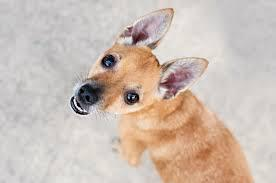

In [11]:
# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image path
# First we set seed to get the same result every time
random.seed(42)

random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

# 3. Transforming data

Before we can use our image data with PyTorch we have to:
1. Turn our data into tensors.
2. Then turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`.



## 3.1 `torchvision.transforms`

Transforms help us get the images ready to be used with a model/perform data augmentation.

In [12]:
first_data_transform = transforms.Compose([
  # Resize our images to 64x64
  transforms.Resize(size=(64, 64)),
  # Turn the image into a torch.Tensor
  transforms.ToTensor()
])

second_data_transform = transforms.Compose([
  transforms.Resize(size=(224, 224)),
  transforms.ToTensor()
])

third_data_transform = transforms.Compose([
  transforms.Resize(size=(224, 224)),
  # data augmentation with TrivialAugmentWide
  transforms.TrivialAugmentWide(num_magnitude_bins=31),
  transforms.ToTensor()
])

In [13]:
# Checking the output for the random image that we choose before
first_data_transform(img).shape

torch.Size([3, 64, 64])

[3, 64, 64] -> [number of color_channels, height, width]

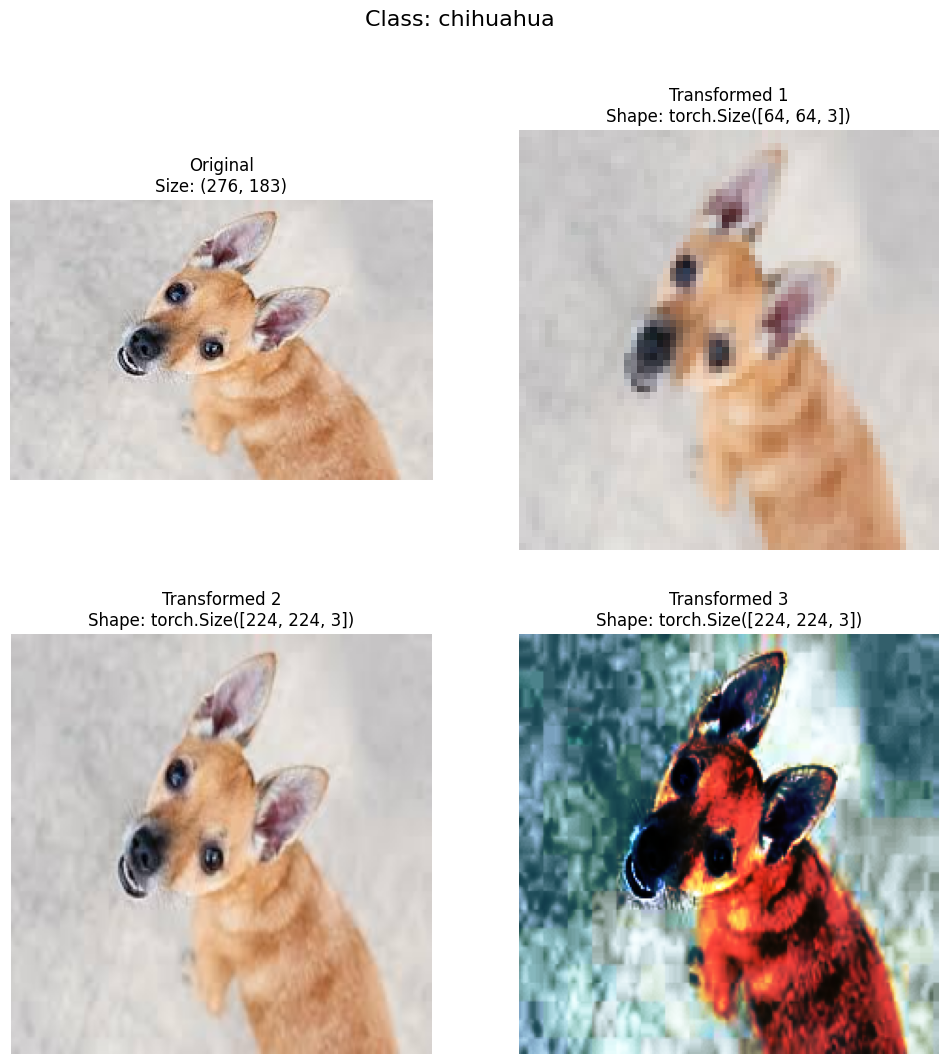

<Figure size 1200x600 with 0 Axes>

In [14]:
with Image.open(random_image_path) as f:
  fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
  plt.figure(figsize=(12, 6))
  ax[0][0].imshow(f)
  ax[0][0].set_title(f"Original\nSize: {f.size}")
  ax[0][0].axis(False)

  # Transform and plot target image
  transformed_image = first_data_transform(f).permute(1, 2, 0) # note we will need to change shape for matplotlib (C, H, W) -> (H, W, C)
  ax[0][1].imshow(transformed_image)
  ax[0][1].set_title(f"Transformed 1\nShape: {transformed_image.shape}")
  ax[0][1].axis("off")

  transformed_image = second_data_transform(f).permute(1, 2, 0)
  ax[1][0].imshow(transformed_image)
  ax[1][0].set_title(f"Transformed 2\nShape: {transformed_image.shape}")
  ax[1][0].axis("off")

  transformed_image = third_data_transform(f).permute(1, 2, 0)
  ax[1][1].imshow(transformed_image)
  ax[1][1].set_title(f"Transformed 3\nShape: {transformed_image.shape}")
  ax[1][1].axis("off")

  fig.suptitle(f"Class: {random_image_path.parent.stem}", fontsize=16)

# 4. Loading image data

We would load image classification data using `torchvision.datasets.ImageFolder`.

In [15]:
# Use ImageFolder to create dataset(s)
def train_test_data(transform):
  train_data = datasets.ImageFolder(root=train_dir,
                                  transform=transform, # a transform for the data
                                  target_transform=None) # a transform for the label/target

  test_data = datasets.ImageFolder(root=test_dir,
                                 transform=transform)

  return train_data, test_data

In [16]:
train_data, test_data = train_test_data(first_data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 4733
     Root location: data/muffin_chihuahua/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 1184
     Root location: data/muffin_chihuahua/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [17]:
# Get class names as list
class_names = train_data.classes
class_names

['chihuahua', 'muffin']

In [18]:
# Get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'chihuahua': 0, 'muffin': 1}

In [19]:
# Check the lengths of our dataset
len(train_data), len(test_data)

(4733, 1184)

In [20]:
# with using ``samples`` we get two value, the path of the image and the target value (In our case we get the values for the first image in train_data)
print(f"path: {train_data.samples[0][0]}, \nlabel: {train_data.samples[0][1]}")

path: data/muffin_chihuahua/train/chihuahua/img_0_0.jpg, 
label: 0


In [21]:
# Index on the train_data Dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n {img}")
print(f"Image shape: {img.shape}") # [C, H, W]
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
 tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [0.9373, 0.9412, 0.9451,  ..., 1.0000, 1.0000, 1.0000],
         [0.7686, 0.7961, 0.8314,  ..., 1.0000, 1.0000, 1.0000],
         [0.8745, 0.8745, 0.8902,  ..., 1.0000, 1.0000, 1.0000]],

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [0.9373, 0.9412, 0.9451,  ..., 1.0000, 1.0000, 1.0000],
         [0.7686, 0.7961, 0.8314,  ..., 1.0000, 1.0000, 1.0000],
         [0.8745, 0.8745, 0.8902,  ..., 1.0000, 1.0000, 1.0000]],

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute: torch.Size([64, 64, 3]) -> [height, width, color_channels]


Text(0.5, 1.0, 'Class: chihuahua\nshape: torch.Size([64, 64, 3])')

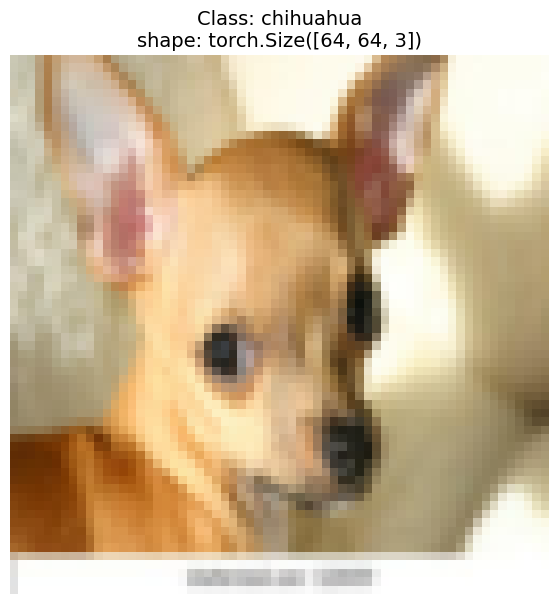

In [22]:
# set seed
random.seed(42)

# 1. Get random sample indexes
random_samples_idx = random.choice(range(len(train_data)))

img, label = train_data[random_samples_idx][0], train_data[random_samples_idx][1]

# Rearrange the order dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(f"Class: {class_names[label]}\nshape: {img_permute.shape}", fontsize=14)

## 4.1 Turn loaded images into `DataLoader`'s

A `DataLoader` is going to help us turn our `Dataset`'s into iterables and we can customise the `batch_size` so our model can see `batch_size` images at a time.

In [45]:
torch.cuda.device_count(), os.cpu_count()

(1, 2)

In [27]:
# Turn train and test datasets into DataLoader's
def train_test_dataloader(train_data, test_data, BATCH_SIZE=32, NUM_WORKERS=None):
  if NUM_WORKERS is None:
    if torch.cuda.is_available():
      NUM_WORKERS=torch.cuda.device_count()
    else:
      NUM_WORKERS= os.cpu_count()
  else:
    pass


  train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=True)

  test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS,
                             shuffle=False)
  print(f"train data loader: {train_dataloader}")
  print(f"test data loader: {test_dataloader}")
  print(f"\nLength of train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE} images")
  print(f"Length of test_dataloader: {len(test_dataloader)} batches of {BATCH_SIZE} images")
  return train_dataloader, test_dataloader

In [28]:
train_dataloader, test_dataloader = train_test_dataloader(train_data, test_data)

train data loader: <torch.utils.data.dataloader.DataLoader object at 0x7a666e53d480>
test data loader: <torch.utils.data.dataloader.DataLoader object at 0x7a666e53ea10>

Length of train_dataloader: 148 batches of 32 images
Length of test_dataloader: 37 batches of 32 images


In [29]:
img, label = next(iter(train_dataloader))

print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Image shape: torch.Size([32, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


# 5. Model 0: TinyVGG without data augmentation

Let's replicate TinyVGG architecture from the CNN Explainer website: https://poloclub.github.io/cnn-explainer/

In [113]:
# 1. Load and transform data
train_data_simple, test_data_simple = train_test_data(first_data_transform)

# 2. Turn the datasets into DataLoaders
train_dataloader_simple, test_dataloader_simple = train_test_dataloader(train_data_simple, test_data_simple)

train data loader: <torch.utils.data.dataloader.DataLoader object at 0x7a666e53fd90>
test data loader: <torch.utils.data.dataloader.DataLoader object at 0x7a666e53fc40>

Length of train_dataloader: 148 batches of 32 images
Length of test_dataloader: 37 batches of 32 images


In [114]:
class TinyVGG(nn.Module):
  """
  Model architecture copying TinyVGG from CNN Explainer: https://poloclub.github.io/cnn-explainer/
  """
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2) # default stride value is same as kernel_size
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*13*13, # Our transform process make the pictures of size 64*64 and after passing through our layers it becomes 13*13
                  out_features=output_shape)
    )

  def forward(self, x):
    return self.classifier(self.conv_block_2(self.conv_block_1(x)))

In [115]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels in our image data
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=2, bias=True)
  )
)

### 5.1 to test the model I perform a forward pass on a single image

In [44]:
# Get a single image batch
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [45]:
# Try a forward pass
model_0(image_batch.to(device))

tensor([[0.0071, 0.0093],
        [0.0058, 0.0072],
        [0.0081, 0.0080],
        [0.0071, 0.0069],
        [0.0069, 0.0089],
        [0.0066, 0.0101],
        [0.0038, 0.0120],
        [0.0066, 0.0097],
        [0.0089, 0.0087],
        [0.0106, 0.0065],
        [0.0059, 0.0093],
        [0.0089, 0.0063],
        [0.0068, 0.0093],
        [0.0052, 0.0084],
        [0.0077, 0.0046],
        [0.0074, 0.0072],
        [0.0078, 0.0092],
        [0.0055, 0.0099],
        [0.0066, 0.0091],
        [0.0038, 0.0143],
        [0.0073, 0.0085],
        [0.0091, 0.0047],
        [0.0086, 0.0063],
        [0.0067, 0.0099],
        [0.0071, 0.0097],
        [0.0054, 0.0107],
        [0.0113, 0.0069],
        [0.0070, 0.0080],
        [0.0074, 0.0092],
        [0.0090, 0.0063],
        [0.0083, 0.0059],
        [0.0069, 0.0088]], grad_fn=<AddmmBackward0>)

In [35]:
# Use `torchinfo.summary` to get an idea of the shapes going through our model
summary(model_0, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 2]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

## 5.2 Create train and test loops functions

* `train_step()` - takes in a model and dataloader and trains the model on the dataloader.
* `test_step()` - takes in a model and dataloader and evaluates the model on the dataloader.

In [116]:
# Create train_step()
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               device=device):
  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss = 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
    # Send data to the target device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X) # output model logits

    # 2. Calculate the loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate accuracy metric
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  return train_loss

In [117]:
# Create a test step
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
  # Put model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss = 0

  # Turn on inference mode
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(dataloader):
      # Send data to the target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      test_pred_logits = model(X)

      # 2. Calculate the loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # Calculate the accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  return test_loss

In [118]:
# 1. Create a train function that takes in various model parameters + optimizer + dataloaders + loss function
def train_fn(model: torch.nn.Module,
          train_dataloader,
          optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device=device):

  # 2. Create empty results dictionary
  results = {"train_loss": []}

  # 3. Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    train_loss = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)

    # 4. Print out what's happening
    print(f"Epoch: {epoch} | Train loss: {train_loss:.4f}")

    # 5. Update results dictionary
    results["train_loss"].append(train_loss)

  # 6. Return the filled results at the end of the epochs
  return results

In [119]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                             lr=0.001)

# Start the timer
start_time = timer()

# Train model_0
model_0_results = train_fn(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 0 | Train loss: 0.6919
Epoch: 1 | Train loss: 0.6906
Epoch: 2 | Train loss: 0.6902
Epoch: 3 | Train loss: 0.6901
Epoch: 4 | Train loss: 0.6901
Total training time: 269.005 seconds


In [120]:
test_loss = test_step(model=model_0,
                      dataloader=test_dataloader,
                      loss_fn=nn.CrossEntropyLoss(),
                      device=device)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [121]:
test_loss

0.690002035450291